# Predictive Analysis

This notebook implements three key predictive analysis techniques:
1. Linear regression for price prediction based on ratings
2. Stock availability analysis to identify trends
3. Basic content-based recommendation system using similarity metrics

In [11]:
import pandas as pd

In [12]:
# Load the books dataset
df = pd.read_csv('../data_processing/cleaned_data.csv')
df

,title,price,rating,availability
0,a light in the attic,51.77,3,in stock
1,tipping the velvet,53.74,1,in stock
2,soumission,50.10,1,in stock
3,sharp objects,47.82,4,in stock
4,sapiens a brief history of humankind,54.23,5,in stock
...,...,...,...,...
995,alice in wonderland alices adventures in wonde...,55.53,1,in stock
996,ajin demihuman volume 1 ajin demihuman 1,57.06,4,in stock
997,a spys devotion the regency spies of london 1,16.97,5,in stock
998,1st to die womens murder club 1,53.98,1,in stock


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Linear Regression for Price Prediction

In [14]:
# Prepare data for regression
regression_data = df.dropna(subset=['price', 'rating'])
X = regression_data[['rating']]
y = regression_data['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Coefficient (β₁): {model.coef_[0]:.4f}")
print(f"Model Intercept (β₀): {model.intercept_:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Model Coefficient (β₁): 0.3601
Model Intercept (β₀): 34.2345
Mean Squared Error: 211.4538
R² Score: -0.0066


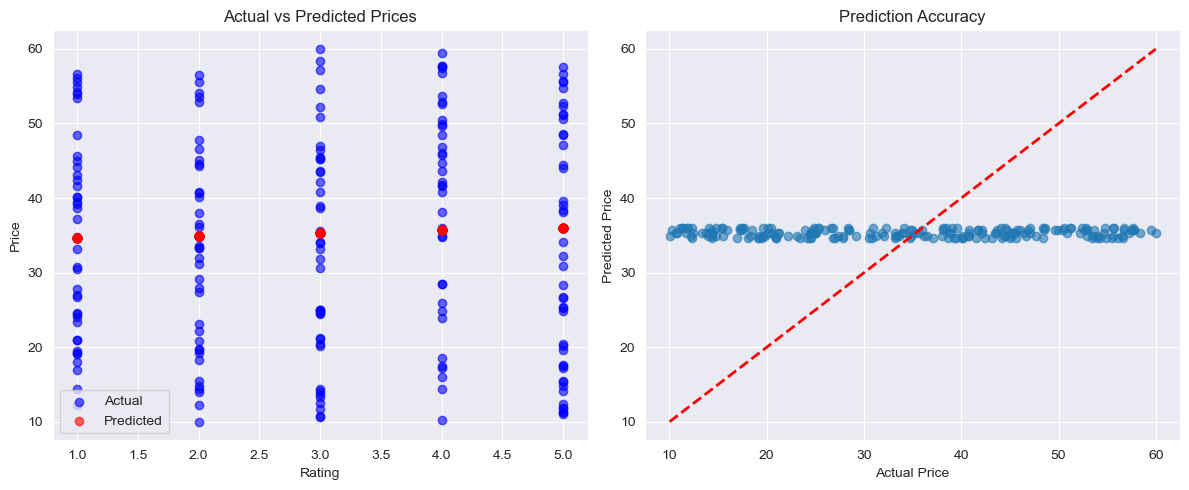

In [15]:
# Visualize regression results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test, y_test, alpha=0.6, color='blue', label='Actual')
plt.scatter(X_test, y_pred, alpha=0.6, color='red', label='Predicted')
plt.xlabel('Rating')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Prediction Accuracy')

plt.tight_layout()
plt.show()

## 2. Stock Availability Analysis

In [16]:
# Analyze relationship between stock status, price, and rating
stock_analysis = df.groupby('availability').agg({
    'price': ['mean', 'median', 'count'],
    'rating': ['mean', 'median']
}).round(2)

stock_analysis.columns = ['_'.join(col).strip() for col in stock_analysis.columns]
print("Stock Status Analysis:")
print(stock_analysis)

Stock Status Analysis:
              price_mean  price_median  price_count  rating_mean  \
availability                                                       
in stock           35.07         35.98         1000         2.92   

              rating_median  
availability                 
in stock                3.0  


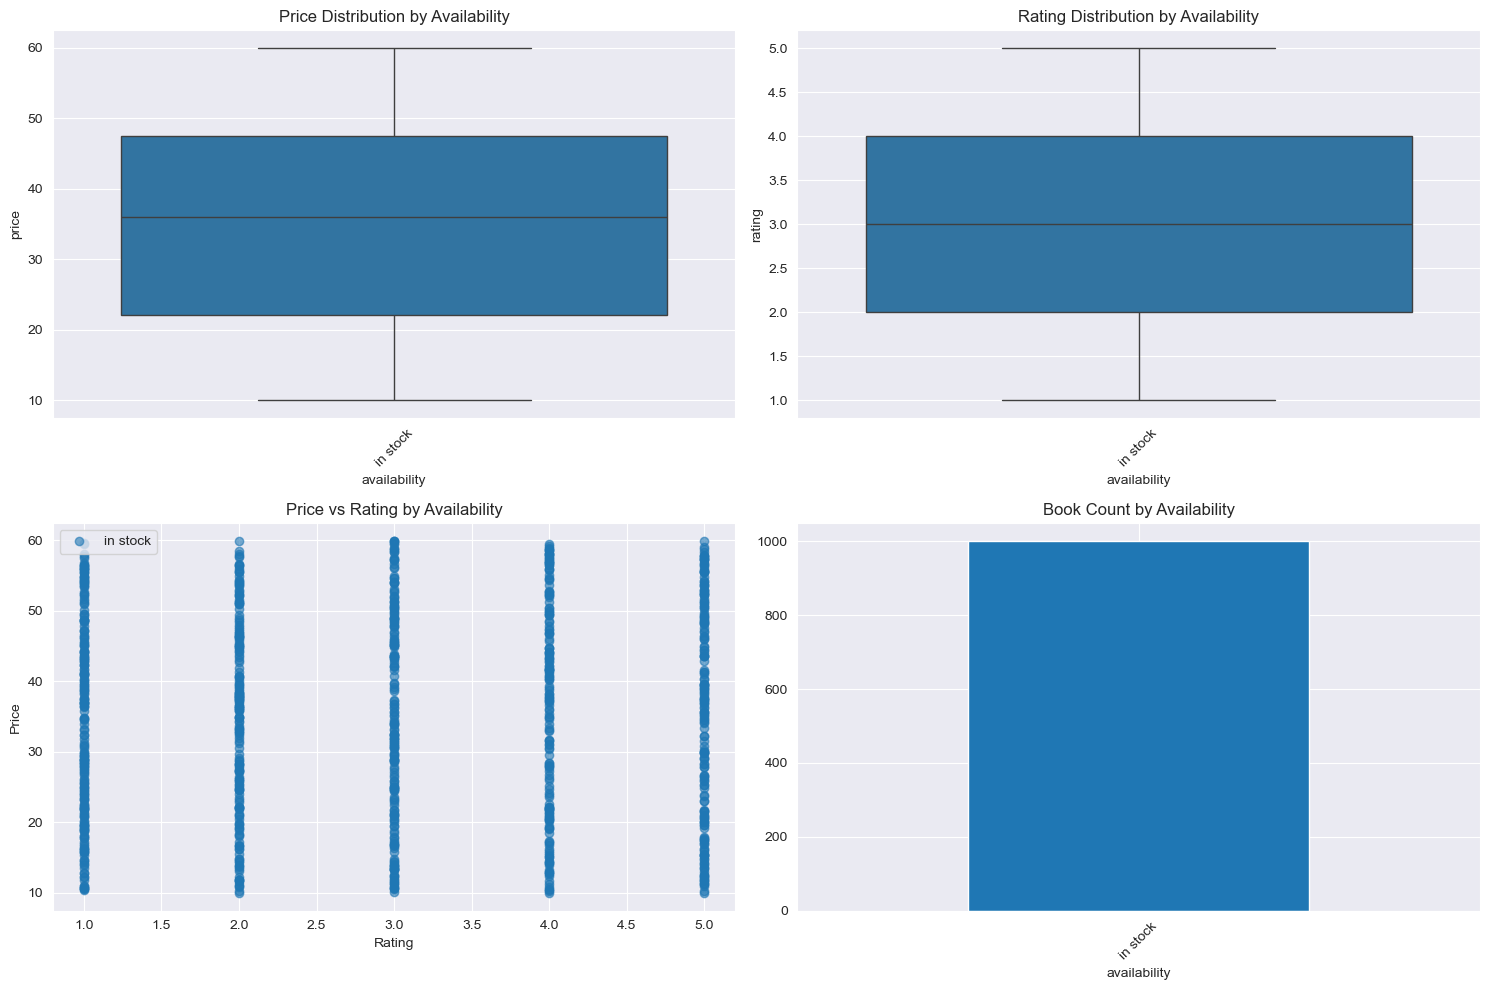

In [17]:
# Visualize stock availability trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price distribution by availability
sns.boxplot(data=df, x='availability', y='price', ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution by Availability')
axes[0, 0].tick_params(axis='x', rotation=45)

# Rating distribution by availability
sns.boxplot(data=df, x='availability', y='rating', ax=axes[0, 1])
axes[0, 1].set_title('Rating Distribution by Availability')
axes[0, 1].tick_params(axis='x', rotation=45)

# Price vs Rating colored by availability
for i, status in enumerate(df['availability'].unique()):
    subset = df[df['availability'] == status]
    axes[1, 0].scatter(subset['rating'], subset['price'], alpha=0.6, label=status)
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Price')
axes[1, 0].set_title('Price vs Rating by Availability')
axes[1, 0].legend()

# Count of books by availability
df['availability'].value_counts().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Book Count by Availability')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [18]:
# Identify patterns: high-rated, low-priced books that are out of stock
price_threshold = df['price'].quantile(0.3)  # Bottom 30% prices
rating_threshold = df['rating'].quantile(0.7)  # Top 30% ratings

high_demand_books = df[
    (df['price'] <= price_threshold) &
    (df['rating'] >= rating_threshold)
    ]

print(f"High-rated ({rating_threshold}+), low-priced (<={price_threshold:.2f}) books:")
print(f"Total books: {len(high_demand_books)}")
print("\nStock status distribution:")
print(high_demand_books['availability'].value_counts())

High-rated (4.0+), low-priced (<=25.01) books:
Total books: 114

Stock status distribution:
availability
in stock    114
Name: count, dtype: int64


## 3. Content-Based Recommendation System

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
# Create feature vectors for recommendation
# Combine title words with price range and rating
def create_price_range(price):
    if price < 20:
        return 'low_price'
    elif price < 40:
        return 'medium_price'
    else:
        return 'high_price'


df['price_range'] = df['price'].apply(create_price_range)
df['rating_category'] = df['rating'].apply(lambda x: f'rating_{int(x)}')

# Combine features into text
df['combined_features'] = (
        df['title'].fillna('') + ' ' +
        df['price_range'] + ' ' +
        df['rating_category']
)

# Create TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

# Calculate similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

In [21]:
def get_recommendations(book_title, n_recommendations=5):
    """Get book recommendations based on similarity"""
    try:
        # Find book index
        book_idx = df[df['title'].str.contains(book_title, case=False, na=False)].index[0]

        # Get similarity scores
        sim_scores = list(enumerate(similarity_matrix[book_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get top recommendations (excluding the book itself)
        book_indices = [i[0] for i in sim_scores[1:n_recommendations + 1]]

        recommendations = df.iloc[book_indices][['title', 'price', 'rating', 'availability']]
        similarities = [sim_scores[i + 1][1] for i in range(n_recommendations)]
        recommendations['similarity_score'] = similarities

        return recommendations

    except IndexError:
        return f"Book '{book_title}' not found in dataset"


# Example recommendation
sample_book = df.iloc[0]['title']
print(f"Recommendations for '{sample_book}':")
recommendations = get_recommendations(sample_book)
print(recommendations)

Recommendations for 'a light in the attic':
                            title  price  rating availability  \
340   all the light we cannot see  29.87       5     in stock   
929    the light of the fireflies  54.43       1     in stock   
259              take me with you  45.21       3     in stock   
327  catching jordan hundred oaks  50.83       3     in stock   
522                     meternity  43.58       3     in stock   

     similarity_score  
340          0.802806  
929          0.621417  
259          0.442346  
327          0.442346  
522          0.442346  


In [22]:
# Recommendation system performance analysis
def analyze_recommendation_diversity():
    """Analyze the diversity of recommendations"""
    sample_books = df.sample(10, random_state=42)

    all_recommendations = []
    for _, book in sample_books.iterrows():
        recs = get_recommendations(book['title'], n_recommendations=3)
        if isinstance(recs, pd.DataFrame):
            all_recommendations.extend(recs['title'].tolist())

    unique_recommendations = len(set(all_recommendations))
    total_recommendations = len(all_recommendations)

    print(f"Recommendation Diversity Analysis:")
    print(f"Total recommendations made: {total_recommendations}")
    print(f"Unique books recommended: {unique_recommendations}")
    print(f"Diversity ratio: {unique_recommendations / total_recommendations:.2f}")


analyze_recommendation_diversity()

Recommendation Diversity Analysis:
Total recommendations made: 30
Unique books recommended: 30
Diversity ratio: 1.00


In [23]:
# Create recommendation function for interactive use
def recommend_similar_books(title_query, top_n=5):
    """Interactive recommendation function"""
    matching_books = df[df['title'].str.contains(title_query, case=False, na=False)]

    if len(matching_books) == 0:
        print(f"No books found matching '{title_query}'")
        return

    print(f"Found {len(matching_books)} matching books:")
    for idx, book in matching_books.head(3).iterrows():
        print(f"- {book['title']} (Price: ${book['price']:.2f}, Rating: {book['rating']})")

    if len(matching_books) > 0:
        selected_book = matching_books.iloc[0]['title']
        print(f"\nRecommendations for '{selected_book}':")
        recs = get_recommendations(selected_book, top_n)
        if isinstance(recs, pd.DataFrame):
            for idx, rec in recs.iterrows():
                print(
                    f"• {rec['title']} - ${rec['price']:.2f} - Rating: {rec['rating']} - Similarity: {rec['similarity_score']:.3f}")


# Example usage
recommend_similar_books("light", 3)


Found 14 matching books:
- a light in the attic (Price: $51.77, Rating: 3)
- a flight of arrows the pathfinders 2 (Price: $55.53, Rating: 5)
- the power of now a guide to spiritual enlightenment (Price: $43.54, Rating: 2)

Recommendations for 'a light in the attic':
• all the light we cannot see - $29.87 - Rating: 5 - Similarity: 0.803
• the light of the fireflies - $54.43 - Rating: 1 - Similarity: 0.621
• take me with you - $45.21 - Rating: 3 - Similarity: 0.442
